In [8]:
from datacube.utils.dask import start_local_dask
from dep_tools.loaders import Sentinel2OdcLoader
from dep_tools.namers import DepItemPath
from dep_tools.writers import LocalDsWriter
from pystac import Item

from src.run_task import MangrovesProcessor, get_areas

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Optionally set up a local dask cluster
client = start_local_dask()
client.dashboard_link

'http://127.0.0.1:8787/status'

In [14]:
# Study site configuration
region_code = "PG"
region_index = "051"
datetime = "2023"
dep_path = DepItemPath("s2", "mangroves", "0.0.0", datetime, local_folder="data")
item_id = f"{region_code}_{region_index}"

# Set up a data loader
loader = Sentinel2OdcLoader(
    epsg=3832,
    datetime=datetime,
    dask_chunksize=dict(band=1, time=1, x=4096, y=4096),
    odc_load_kwargs=dict(fail_on_error=False, resolution=10, bands=["SCL", "B04", "B08"]),
)

# And a data processor
processor = MangrovesProcessor()

# And get the study site
areas = get_areas(region_code, region_index)
areas.explore()

In [15]:
# Run the load process, which uses Dask, so it's fast
input_data = loader.load(areas)
input_data

<xarray.DataArray 'data' (band: 3, time: 106, y: 10591, x: 9759)>
dask.array<where, shape=(3, 106, 10591, 9759), dtype=float32, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 -9.752e+05 -9.753e+05 ... -1.081e+06 -1.081e+06
  * x            (x) float64 -3.794e+05 -3.794e+05 ... -2.818e+05 -2.818e+05
  * time         (time) datetime64[ns] 2023-01-01T00:37:09.024000 ... 2023-09...
  * band         (band) object 'SCL' 'B04' 'B08'
    spatial_ref  int64 0
Attributes:
    _FillValue:  nan

In [16]:
# Load data into memory. This will take 5-10 minutes or so.
output_data = processor.process(input_data)
output_data

/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/opt/homebrew/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.Dataset>
Dimensions:      (y: 10591, x: 9759)
Coordinates:
  * y            (y) float64 -9.752e+05 -9.753e+05 ... -1.081e+06 -1.081e+06
  * x            (x) float64 -3.794e+05 -3.794e+05 ... -2.818e+05 -2.818e+05
    spatial_ref  int64 0
Data variables:
    ndvi         (y, x) float32 0.3867 0.3435 0.3344 ... 0.6296 0.6453 0.6631
    mangroves    (y, x) int16 0 0 0 0 0 0 0 0 0 ... -32767 -32767 1 1 1 1 1 1
Attributes:
    stac_properties:  {'start_datetime': '2023-01-01T00:00:00.000Z', 'datetim...

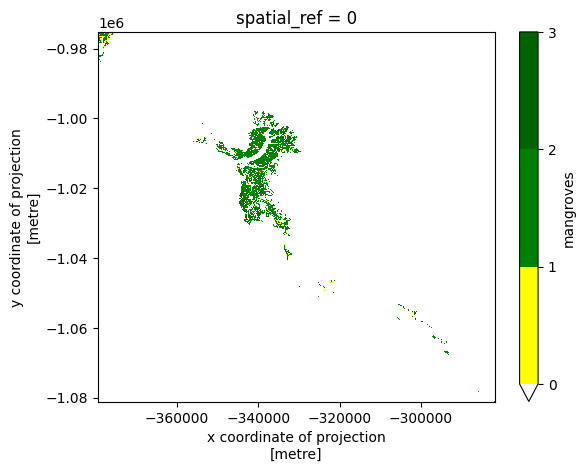

In [26]:
# Plot data. Yellow is not-mangrove, green is open and dark green is closed 
output_data.mangroves.plot.imshow(levels=[0, 1, 2, 3], colors=["white", "yellow", "green", "darkgreen"])

In [32]:
from dep_tools.namers import LocalPath

# Write out files
dep_path = LocalPath(local_folder="data", sensor="s2", dataset_id="mangroves", version="0.0.0", time=datetime)
# dep_path._folder_prefix = "data"

writer = LocalDsWriter(itempath=dep_path)
out_files = writer.write(output_data, item_id)

data/dep_s2_mangroves_PG_051_2023_ndvi.tif


In [34]:
# Make sure written files are readable
stac_path = writer.itempath.path(item_id, ext=".stac-item.json")

item = Item.from_file(stac_path)
item.validate()

['https://schemas.stacspec.org/v1.0.0/item-spec/json-schema/item.json',
 'https://stac-extensions.github.io/projection/v1.1.0/schema.json']